<a href="https://colab.research.google.com/github/LucasParreirasDS/Projects/blob/main/ClientSegmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project UK Merch 
The objective of this project is to solve a problem for an young company which is dedicated to the clothing wholesale and we need to sementate their client based on database we downloaded.



## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime as dt
from datetime import timedelta as td

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading dataset

In [2]:
df_original = pd.read_csv('data/raw/vendas-por-fatura.csv')
df_original.shape

(25953, 6)

In [3]:
df_original.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.00,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.00,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.00,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.00,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.00,United Kingdom,357,"344,83"


In [4]:
df = df_original.copy()

In [5]:
df.columns = ['id_transaction', 'date', 'id_client', 'country', 'products', 'monetary']
df.head(5)

,id_transaction,date,id_client,country,products,monetary
0,548370,3/30/2021 16:14:00,15528.00,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.00,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.00,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.00,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.00,United Kingdom,357,"344,83"


### Dictionary
- id_transaction - Unique Id for each transaction. If it starts with an I it's a replacement transaction
- date - Date and time of transaction
- id_client - Unique Id for clients
- country - Country where the client lives
- products - The number of products. If it is negative it's a replacement transaction
- value - The total of the transaction in sterling pounds

### Data Overview

In [6]:
df.isnull().sum()

id_transaction       0
date                 0
id_client         3724
country              0
products             0
monetary             0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_transaction  25953 non-null  object 
 1   date            25953 non-null  object 
 2   id_client       22229 non-null  float64
 3   country         25953 non-null  object 
 4   products        25953 non-null  int64  
 5   monetary        25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB



- 'id_client' should be string
- 'date' should be datetime and we dont need time
- 'value' is separating decimals with a comma, so it's as string. We're going to fix it and transform to float.



The Client Id is a crucial information for reaching the objective of the project and it's impossible to discover what it should be based on the other columns. <br> 
Beacuse of this, we're going transform id_client to string and sinalize the ones that were null with 'Unknown'

In [8]:
df = df.dropna().reset_index(drop=True)

### Transforming data to analysis

In [9]:
df['id_client'] = df['id_client'].apply(lambda x: str(int(x))) # client id to string

In [10]:
df['date'] = df['date'].apply(lambda x: dt.strptime(x.split(' ')[0], '%m/%d/%Y')) # date to datetime

In [11]:
df['monetary'] = df['monetary'].apply(lambda x: float(x.replace(',', '.'))) # replacing ',' for '.' and converting to float

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22229 entries, 0 to 22228
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_transaction  22229 non-null  object        
 1   date            22229 non-null  datetime64[ns]
 2   id_client       22229 non-null  object        
 3   country         22229 non-null  object        
 4   products        22229 non-null  int64         
 5   monetary        22229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.0+ MB


In [13]:
df[df.duplicated()]

,id_transaction,date,id_client,country,products,monetary
8340,C581390,2021-12-08,13081,United Kingdom,-13,-15.85
9662,568417,2021-09-27,14911,EIRE,202,776.30
10774,C581384,2021-12-08,17673,United Kingdom,-2,-6.90
11198,568423,2021-09-27,17061,United Kingdom,118,573.40
11235,568387,2021-09-27,13704,United Kingdom,340,422.32
13636,568384,2021-09-27,12748,United Kingdom,1,0.00
16159,C581323,2021-12-08,14442,Channel Islands,-1,-4.25
19346,C581330,2021-12-08,15877,United Kingdom,-125,-52.50


In [14]:
df[df.id_transaction == '568423']

,id_transaction,date,id_client,country,products,monetary
1754,568423,2021-09-27,17061,United Kingdom,118,573.40
11198,568423,2021-09-27,17061,United Kingdom,118,573.40


In [15]:
df = df.drop_duplicates(keep='first')
df.shape

(22221, 6)

## Feature Engineering

We're going to segment customers using the RFM Method. It consists in scoring each customer for:
 - Recency (last time made an transaction)
 - Frequency (how many transaction did the customer made since his first one)
 - Monetary (how much  did he spent sice first transaction)

Getting information about clients.
- When was the first transaction for each customer?
- When was the last?
- For how many days the customer was a member?
- How many transactions in this time?
- How much did he spent?

In [16]:
df = df[~(df['monetary'] < 0)].reset_index(drop=True)

In [17]:
df.head()

,id_transaction,date,id_client,country,products,monetary
0,548370,2021-03-30,15528,United Kingdom,123,229.33
1,575767,2021-11-11,17348,United Kingdom,163,209.73
2,549106,2021-04-06,17045,United Kingdom,1,39.95
3,573112,2021-10-27,16416,United Kingdom,357,344.83
4,576630,2021-11-16,13816,Germany,91,199.98


In [18]:
# Sorting the data by client id and date
data_date = df[['id_client', 'date']].sort_values(['id_client', 'date']).reset_index(drop=True)  
data_date.head(10)

,id_client,date
0,12346,2021-01-18
1,12347,2020-12-07
2,12347,2021-01-26
3,12347,2021-04-07
4,12347,2021-06-09
5,12347,2021-08-02
6,12347,2021-10-31
7,12347,2021-12-07
8,12348,2020-12-16
9,12348,2021-01-25


Now that we have a dataframe ordered  by client id and date, we can iterate through it rows to discover first date, last date and count how many transactions. 

In [19]:
count = 1 # starting the count
client_date = {} # creating a dict to store client data about dates
first_day = data_date['date'][0]
last_day = data_date['date'][0]
for idx, row in data_date.iterrows():
  if idx != len(data_date)-1:
    if row['id_client'] == data_date['id_client'][idx+1]:
      count += 1                                                       # (How many transactions in this time?)
      last_day = data_date['date'][idx+1]                              # (When was the last?)
    else:
      client_date[row['id_client']] = [first_day, last_day, count]
      count = 1
      first_day = data_date['date'][idx+1]                             # (When was the first transaction for each customer?)
      last_day = data_date['date'][idx+1]
  else:
      client_date[row['id_client']] = [first_day, last_day, count]



In [20]:
# Creating the dataframe for informations about date
df_client = pd.DataFrame(client_date).T
df_client.reset_index(inplace=True)
df_client.columns = ['id_client', 'first_day', 'last_day', 'frequency']

In [21]:
# How many days is the customer a member? It will be used for normalize data
interval = df_client['last_day']- df_client['first_day']
interval = interval.apply(lambda x: x.days)

In [22]:
df_client['interval'] = interval
df_client['frequency'] = pd.to_numeric(df_client['frequency'])
df_client.head()

,id_client,first_day,last_day,frequency,interval
0,12346,2021-01-18,2021-01-18,1,0
1,12347,2020-12-07,2021-12-07,7,365
2,12348,2020-12-16,2021-09-25,4,283
3,12349,2021-11-21,2021-11-21,1,0
4,12350,2021-02-02,2021-02-02,1,0


In [23]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id_client  4339 non-null   object        
 1   first_day  4339 non-null   datetime64[ns]
 2   last_day   4339 non-null   datetime64[ns]
 3   frequency  4339 non-null   int64         
 4   interval   4339 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 169.6+ KB


In [24]:
df_client.sort_values('last_day').tail(1) # this is the last day of the data set

,id_client,first_day,last_day,frequency,interval
3190,16705,2020-12-16,2021-12-09,20,358


We will calculate de Recency (from RFM) that is the last day the costumer made an action. We need a number of days to actual date. I'm coding this in 05/2022, and the last transaction of data set was beginning of December 2021, so i will consider the actual date as December 31 2021.

In [25]:
'''
recency_2 = []
date = dt.strptime('2021-12-31', '%Y-%m-%d')
df_client['last_day'].apply(lambda x: recency_2.append(date-x))
recency_2[:5]
'''

"\nrecency_2 = []\ndate = dt.strptime('2021-12-31', '%Y-%m-%d')\ndf_client['last_day'].apply(lambda x: recency_2.append(date-x))\nrecency_2[:5]\n"

In [26]:
recency = []
for c in range(len(df_client)):
  recency.append(int(str(recency_2[c]).split()[0])) # splitting to get only the number of days
recency[: 5]

NameError: name 'recency_2' is not defined

In [ ]:
df_client['recency'] = recency
df_client

,id_client,first_day,last_day,frequency,interval,recency
0,12346,2021-01-18,2021-01-18,1,0,347
1,12347,2020-12-07,2021-12-07,7,365,24
2,12348,2020-12-16,2021-09-25,4,283,97
3,12349,2021-11-21,2021-11-21,1,0,40
4,12350,2021-02-02,2021-02-02,1,0,332
...,...,...,...,...,...,...
4334,18280,2021-03-07,2021-03-07,1,0,299
4335,18281,2021-06-12,2021-06-12,1,0,202
4336,18282,2021-08-05,2021-12-02,2,119,29
4337,18283,2021-01-06,2021-12-06,16,334,25


In [ ]:
# Selecting columns to merge and create our dataframe to be used
data_clients = df.groupby('id_client').sum().sort_values('monetary', ascending=False)
data_clients

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18104\326702902.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_clients = df.groupby('id_client').sum().sort_values('monetary', ascending=False)


,products,monetary
id_client,,
14646,197491,280206.02
18102,64124,259657.30
17450,69993,194550.79
16446,80997,168472.50
14911,80515,143825.06
...,...,...
17956,1,12.75
16454,3,6.90
14792,2,6.20


In [ ]:
data_clients.reset_index(inplace=True)

In [ ]:
# Creating dataframe with RFM information
df_rfm = df_client.merge(data_clients[['id_client', 'monetary']], on='id_client').sort_values('monetary', ascending=False).reset_index(drop=True)

In [ ]:
df_rfm.head()

,id_client,first_day,last_day,frequency,interval,recency,monetary
0,14646,2020-12-20,2021-12-08,74,353,23,280206.02
1,18102,2020-12-07,2021-12-09,60,367,22,259657.30
2,17450,2020-12-07,2021-12-01,46,359,30,194550.79
3,16446,2021-05-18,2021-12-09,2,205,22,168472.50
4,14911,2020-12-01,2021-12-08,202,372,23,143825.06


In [ ]:
df_rfm.describe()

,frequency,interval,recency,monetary
count,4339.00,4339.00,4339.00,4339.00
mean,4.28,130.74,114.04,2053.79
std,7.73,132.21,100.01,8988.25
min,1.00,0.00,22.00,0.00
25%,1.00,0.00,39.00,307.25
50%,2.00,93.00,72.00,674.45
75%,5.00,252.00,163.50,1661.64
max,211.00,373.00,395.00,280206.02


We will normalize the data using rank normalization.<br>
So we rank all the customers based on each of requisites for RFM and divide for the max rank

### Normalizing

In [ ]:
df_rfm['R_rank'] = df_rfm['recency'].rank(ascending=False)
df_rfm['F_rank'] = df_rfm['frequency'].rank(ascending=True)
df_rfm['M_rank'] = df_rfm['monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
df_rfm['R_rank_norm'] = (df_rfm['R_rank']/df_rfm['R_rank'].max())*100
df_rfm['F_rank_norm'] = (df_rfm['F_rank']/df_rfm['F_rank'].max())*100
df_rfm['M_rank_norm'] = (df_rfm['M_rank']/df_rfm['M_rank'].max())*100

We need to weight the 3 attributes of RFM to make it all 100%. So we're using close weights of a text i've found in my research:
- 15% recency
- 30% frquency
- 55% monetary
<br>

We're going to set max score to 5

In [ ]:
df_rfm['RFM_Score'] = 0.15*df_rfm['R_rank_norm']+0.30 * \
    df_rfm['F_rank_norm']+0.55*df_rfm['M_rank_norm']
df_rfm['RFM_Score'] *= 0.05
df_rfm = df_rfm.round(2)
df_rfm[['id_client', 'RFM_Score']].head(7)

,id_client,RFM_Score
0,14646,4.98
1,18102,4.99
2,17450,4.88
3,16446,2.62
4,14911,4.99
5,12415,4.67
6,14156,4.88


Based on my research too, we set this classification for the clients based on their RFM score:
- RFM score > 4.5:  Top Customer
- 4.5 < RFM score > 4.0:  High Value Customer
- 4.0 < RFM score > 3.0:  Medium Value Customer
- 3.0 < RFM score > 1.6:  Low Value Customer
- RFM score =< 1.6:  Lost Customer

In [ ]:
df_rfm["segment"] = np.where(df_rfm['RFM_Score'] > 4.5, "Top",
                        (np.where(df_rfm['RFM_Score'] > 4,    'High value',
                        (np.where(df_rfm['RFM_Score'] > 3,    'Medium Value',
                         np.where(df_rfm['RFM_Score'] > 1.6,  'Low Value', 
                                                              'Lost Customers'))))))
df_rfm['segment'].value_counts()

Lost Customers    1492
Low Value         1164
Medium Value       910
High value         440
Top                333
Name: segment, dtype: int64

Let's take a look at out customers and how they have been classified

In [ ]:
top_high = df_rfm[(df_rfm['segment'] == 'Top') | (df_rfm['segment'] == 'High value')]
print(round(len(top_high)/len(df_rfm) * 100, 2), '% of customers were cassificated as Top or High Value')

17.82 % of customers were cassificated as Top or High Value


In [ ]:
print(round(top_high['monetary'].sum() / df_rfm['monetary'].sum() * 100, 2), '% of total earnings come from Top and High Value costumers')

63.35 % of total earnings come from Top and High Value costumers


As said in the competition's description, we should look for Pareto's Law in this dataset and we can see that about 20% of customers are in Top and High Value classification, although they dont reach 80% of revenue

In [ ]:
df_rfm.head()

,id_client,first_day,last_day,frequency,interval,recency,monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,segment
0,14646,2020-12-20,2021-12-08,74,353,23,280206.02,4253.00,4332.00,4339.00,98.40,99.84,99.84,4.98,Top
1,18102,2020-12-07,2021-12-09,60,367,22,259657.30,4322.00,4329.00,4338.00,100.00,99.77,99.77,4.99,Top
2,17450,2020-12-07,2021-12-01,46,359,30,194550.79,3764.00,4320.00,4337.00,87.09,99.56,99.56,4.88,Top
3,16446,2021-05-18,2021-12-09,2,205,22,168472.50,4322.00,1910.50,4336.00,100.00,44.03,44.03,2.62,Low Value
4,14911,2020-12-01,2021-12-08,202,372,23,143825.06,4253.00,4338.00,4335.00,98.40,99.98,99.98,4.99,Top


In [ ]:
df_rfm[['frequency', 'recency', 'monetary', 'segment']].groupby('segment').mean().sort_values('frequency', ascending=False)

,frequency,recency,monetary
segment,,,
Top,20.91,29.87,12943.11
High value,7.94,45.14,3034.13
Medium Value,4.35,68.22,1620.03
Low Value,2.28,117.90,1010.77
Lost Customers,1.00,178.09,412.58


In [ ]:
df_rfm[['frequency', 'recency', 'monetary', 'segment']].groupby('segment').median().sort_values('monetary', ascending=False)

,frequency,recency,monetary
segment,,,
Top,15.00,26.00,5575.56
High value,7.00,38.00,2466.41
Medium Value,4.00,48.00,1286.38
Low Value,2.00,90.00,606.27
Lost Customers,1.00,153.00,257.28


So we were able to segment company's clients using RFM Method.<br>
I'm very proud because I have never heard about this method before and was suffering in the beggining, but with a little bit of research in the internet everything started to clarify and I think we had a pretty nice result.<br><br>

We can see that Top Customers and High Value Costumers are the most valuable segments and we should invest so that these customers continue to buy and retain their loyalty. <br><br>
Medium Value Costumers have a low frequency but a good monetary spend and we should invest in this costumers to make they buy more frequently, maybe sending exclusive discounts for them sometimes.<br><br>
Lost Customers are customers who made just a single purchase annd maybe we could find out if something happened that they did'nt have a good experience and try to fix it.

### Exploratory Analysis
Now that we could divide customers into different segments, let's take a closer look in what insights we could have

In [ ]:
df.head()

,id_transaction,date,id_client,country,products,monetary
0,548370,2021-03-30,15528,United Kingdom,123,229.33
1,575767,2021-11-11,17348,United Kingdom,163,209.73
2,549106,2021-04-06,17045,United Kingdom,1,39.95
3,573112,2021-10-27,16416,United Kingdom,357,344.83
4,576630,2021-11-16,13816,Germany,91,199.98


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18566 entries, 0 to 18565
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_transaction  18566 non-null  object        
 1   date            18566 non-null  datetime64[ns]
 2   id_client       18566 non-null  object        
 3   country         18566 non-null  object        
 4   products        18566 non-null  int64         
 5   monetary        18566 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 870.4+ KB


In [ ]:
eda_trans = df.merge(df_rfm[['id_client', 'segment']], on='id_client')

In [ ]:
eda_customer = df_rfm[['id_client', 'frequency', 'recency', 'monetary', 'segment']]

In [ ]:
eda_customer = eda_customer.merge(df[['id_client', 'country']],
                                  how='right', 
                                  on='id_client'
                                  ).drop_duplicates(keep='first', subset='id_client')

eda_customer = eda_customer[['id_client', 'frequency', 'recency', 'monetary', 'country', 'segment']].reset_index(drop=True)

In [ ]:
months = eda_trans['date'].apply(lambda x: x.month)

eda_trans['month'] = months

In [ ]:
eda_trans.head(3)

,id_transaction,date,id_client,country,products,monetary,segment,month
0,548370,2021-03-30,15528,United Kingdom,123,229.33,Lost Customers,3
1,575767,2021-11-11,17348,United Kingdom,163,209.73,Medium Value,11
2,578719,2021-11-25,17348,United Kingdom,175,177.61,Medium Value,11


In [ ]:
eda_customer.head(3)

,id_client,frequency,recency,monetary,country,segment
0,15528,1,276,229.33,United Kingdom,Lost Customers
1,17348,5,36,1159.52,United Kingdom,Medium Value
2,17045,3,135,339.44,United Kingdom,Low Value


### Transactions

In [ ]:
eda_trans.head(3)

,id_transaction,date,id_client,country,products,monetary,segment,month
0,548370,2021-03-30,15528,United Kingdom,123,229.33,Lost Customers,3
1,575767,2021-11-11,17348,United Kingdom,163,209.73,Medium Value,11
2,578719,2021-11-25,17348,United Kingdom,175,177.61,Medium Value,11


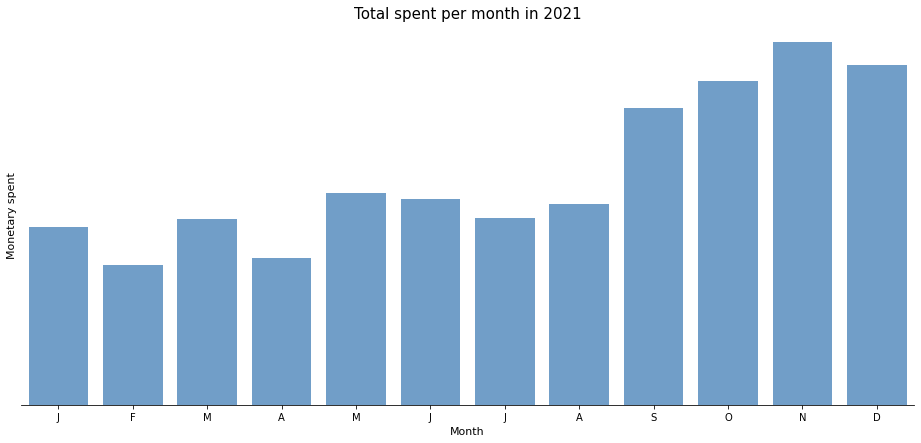

In [ ]:
df_plot = eda_trans.groupby('month')[['products', 'monetary']].sum()

plt.figure(figsize=(16,7))
ax = sns.barplot(data=df_plot, x=df_plot.index, y='monetary', color='#629fd6')
plt.xlabel('Month', {'fontsize': 11})
plt.ylabel('Monetary spent', {'fontsize': 11})
plt.title('Total spent per month in 2021', {'fontsize': 15})
plt.xticks(np.arange(0, 12), labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.tick_params(axis='y',
                left=False,
                labelleft=False)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

- End of the year was the best season for the company
- We can see how the company grew all over the year 

In [ ]:
db = eda_customer.groupby(['country', 'segment'])['segment'].count().unstack(level=1)
db = db.fillna(0)
db['total'] = db[['High value', 'Lost Customers', 'Low Value', 'Medium Value', 'Top']].sum(axis=1)
db = db[(db['total'] > 4) & ((db['Top'] > 0)|(db['High value'] > 0))] 

In [ ]:
data = []

for col in db:
  if col != 'total':
    data.append(db[col] / db['total'] * 100)


In [ ]:
data_plot = pd.DataFrame(data, index=['High Value', 'Lost Customers',	'Low Value', 'Medium Value', 'Top'], columns=data[0].index).T
data_plot = data_plot.sort_values(['Top', 'High Value'])
data_plot

,High Value,Lost Customers,Low Value,Medium Value,Top
country,,,,,
Channel Islands,11.11,33.33,44.44,11.11,0.00
Japan,12.50,37.50,25.00,25.00,0.00
Poland,16.67,33.33,33.33,16.67,0.00
Norway,20.00,40.00,10.00,30.00,0.00
Finland,25.00,41.67,25.00,8.33,0.00
Spain,3.45,34.48,34.48,24.14,3.45
Portugal,10.53,36.84,36.84,10.53,5.26
Italy,7.14,57.14,21.43,7.14,7.14
United Kingdom,10.12,34.40,26.70,21.04,7.73


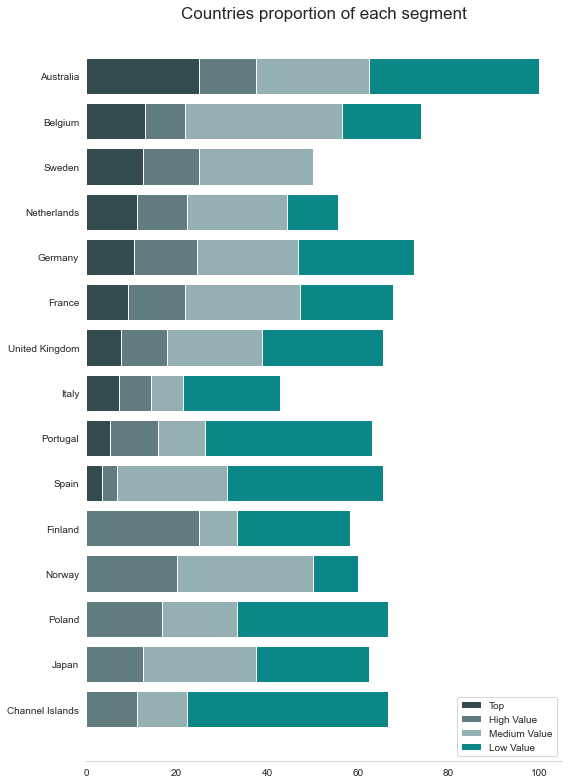

In [ ]:
labels = data_plot.index
top = data_plot['Top']
high = data_plot['High Value']
medium = data_plot['Medium Value']
low = data_plot['Low Value']
lost = data_plot['Lost Customers']
width=0.5

# fig, ax = plt.subplots()
sns.set_style('whitegrid')
plt.figure(figsize=(8, 11))
plt.barh(labels, top[labels], color='#324b4d', label='Top')
plt.barh(labels, high[labels], color='#617c7e', left=top[labels], label='High Value')
plt.barh(labels, medium[labels], color='#94b0b2', left=top[labels]+high[labels], label='Medium Value')
plt.barh(labels, low[labels], color='#0c8787', left=top[labels]+high[labels]+medium[labels], label='Low Value')
plt.title('Countries proportion of each segment', {'fontsize': 17})
plt.legend()
plt.grid(False)
sns.despine(left=True)
plt.tight_layout()

These are the countries that have best % of Top and High Values customers and represents a good decision of UK Merch to expand for them, mainly Australia, Japan and others european countries.

In [ ]:
print(f"{(eda_customer.groupby('country')['monetary'].sum()['United Kingdom'] / eda_customer.groupby('country')['monetary'].sum().sum() * 100).round(2)}% of all revenue come from UK, so let´s take it out for the next chart")

82.01% of all revenue come from UK, so let´s take it out for the next chart


In [ ]:
data_plot = eda_customer.groupby(
    ['country', 'segment'])['monetary'].sum().unstack(level=1).fillna(0)

data_plot = data_plot[(data_plot['Top'] > 0) | (data_plot['High value'] > 0) | (data_plot['Medium Value'] > 0)] 
data_plot.drop('United Kingdom', inplace=True)
data_plot = data_plot.sort_values(['Top', 'High value'], ascending=False).reset_index()
data_plot.head(3)

segment,country,High value,Lost Customers,Low Value,Medium Value,Top
0,Netherlands,822.23,1036.95,1531.44,1849.70,280206.02
1,EIRE,0.00,0.00,0.00,4341.21,261204.69
2,Australia,2780.66,0.00,2969.00,1956.25,131401.98


<Figure size 432x288 with 0 Axes>

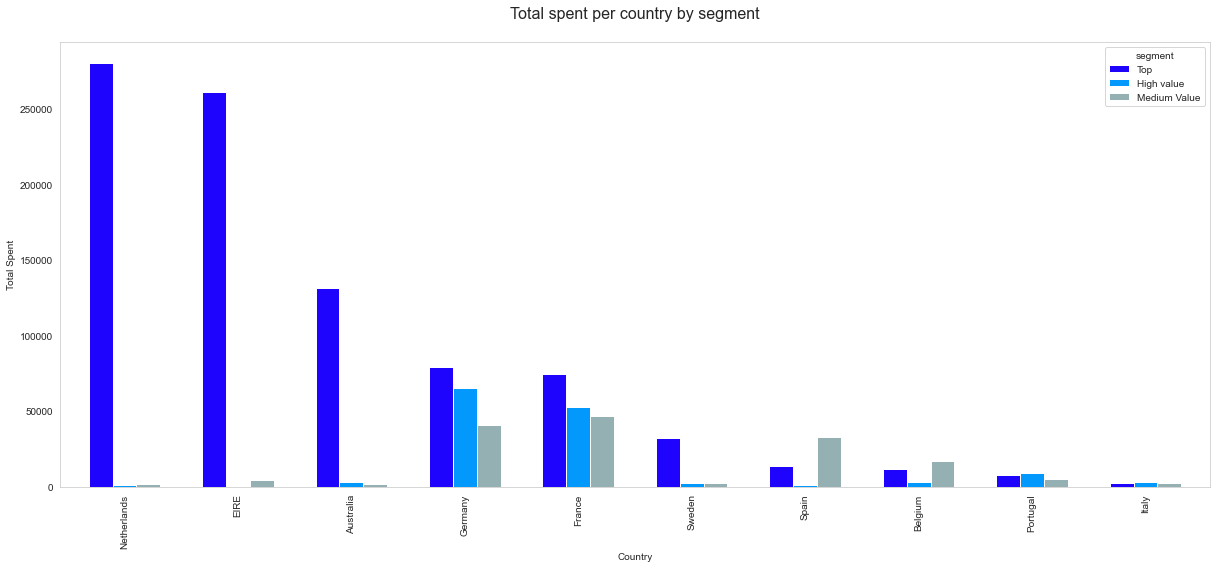

In [ ]:
plt.figure()
data_plot[:10].plot(x='country', y=['Top', 'High value', 'Medium Value'], kind='bar', figsize=(17, 8), color=['#1e03fd', '#0399fc', '#94b0b2'], width=0.63)
plt.title('Total spent per country by segment\n', {'fontsize': 16})
plt.xlabel('Country')
plt.ylabel('Total Spent')
plt.grid(False)
plt.tight_layout()
plt.show()

- Here we can see the countries that have spent the most
- Netherlands, EIRE and Australia are countris with great Top Customers
- Germany and France also have nice customers in Top, High and Medium Value

## Clustering
To finish this projhect, I will just apply a clustering in the countries to practice it and see if it can group those countries outside UK with good results

In [ ]:
X = eda_customer.groupby('country')['frequency', 'recency', 'monetary'].agg({'frequency': 'mean', 'recency': 'mean', 'monetary': 'sum'})

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_18104\4284997215.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  X = eda_customer.groupby('country')['frequency', 'recency', 'monetary'].agg({'frequency': 'mean', 'recency': 'mean', 'monetary': 'sum'})


In [ ]:
clf = KMeans(n_clusters=5)
x = clf.fit(x_scaled)

In [ ]:
X['cluster'] = x.labels_

In [ ]:
X.groupby('cluster').mean()

,frequency,recency,monetary
cluster,,,
0,3.90,99.85,58993.09
1,87.00,79.00,265545.90
2,1.75,324.00,1161.12
3,4.25,113.72,7308391.55
4,2.05,180.73,9397.12


In [ ]:
X

,frequency,recency,monetary,cluster
country,,,,
Australia,7.12,122.12,139107.89,0
Austria,1.67,167.33,9483.50,4
Bahrain,1.00,231.00,548.40,4
Belgium,4.17,118.96,40278.78,0
Brazil,1.00,260.00,1143.60,2
Canada,1.50,207.50,3666.38,4
Channel Islands,2.89,161.78,20450.44,4
Cyprus,2.17,153.33,11775.98,4
Czech Republic,2.00,85.00,826.74,0


- Cluster 3: UK - outlier because it is the country where the company is
- Cluster 1: EIRE - really close to UK and only country that have border to the UK <br>
- Cluster 4: Countries with a good result
<br><br>
- Cluster 2: Countries with bad results that the company might consider stop exporting to  

In [ ]:
X[(X['cluster'] == 1) | (X['cluster'] == 3) | (X['cluster'] == )]

SyntaxError: invalid syntax (272167519.py, line 1)

These are the countries we should be selling.